In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from numpy import mean
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
import string
from string import punctuation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
import googletrans
from googletrans import *
from langdetect import detect

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r'C:\Users\tadeo\Desktop\CA2-Sem2\Data\ProjectTweets.csv', header = None)
pd.set_option('display.max_colwidth', 1000)

In [5]:
df1=df.copy()

In [6]:
tqdm.pandas()

# Drop columns
df1 = df1.drop(columns = [1,3,4]).reset_index(drop = True)

# Split date 
df1[['Day_of_week', 'Month', 'Day', 'Time', 'Timezone', 'Year']] = df1[2].str.split(expand=True)

# Name columns
df1.columns= ['ID','DATE', 'TWEET',  'DAY_OF_WEEK', 'MONTH', 'DAY', 'TIME', 'TIMEZONE', 'YEAR']

# Map months
m_map = {'Jan': '01', 'Feb': '02', 'Mar': '03',
             'Apr': '04', 'May': '05', 'Jun': '06',
             'Jul': '07', 'Aug': '08', 'Sep': '09',
             'Oct': '10', 'Nov': '11', 'Dec': '12'}
df1['MONTH'] = df1['MONTH'].map(m_map)

# Create clean date column
df1['DATE'] = df1['YEAR'] + '-' + df1['MONTH'] + '-' + df1['DAY'] + ' ' + df1['TIME']

# Map days of week
m_map = {'Mon': '01', 'Tue': '02', 'Wed': '03',
         'Thu': '04', 'Fri': '05', 'Sat': '06',
         'Sun': '07',
        }
df1['DAY_OF_WEEK'] = df1['DAY_OF_WEEK'].map(m_map)

# Organize columns
df1 = df1[['ID', 'DATE', 'DAY_OF_WEEK', 'TWEET', 'YEAR', 'MONTH', 'DAY', 'TIME', 'TIMEZONE']]

# Eliminate columns
df1 = df1.drop(columns = ['YEAR', 'MONTH', 'DAY', 'TIME', 'TIMEZONE']).reset_index(drop = True)

# Eliminate https & mentions (@)
df1['TWEET'] = df1['TWEET'].apply(
    lambda tweet: ' '.join(
        ['' if word.startswith('@') and len(word) > 1 or word.startswith('http') else word for word in tweet.split(' ')]
    ))


In [7]:
df1.head()

,ID,DATE,DAY_OF_WEEK,TWEET
0,0,2009-04-06 22:19:45,01,"- Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,1,2009-04-06 22:19:49,01,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,2,2009-04-06 22:19:53,01,I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,3,2009-04-06 22:19:57,01,my whole body feels itchy and like its on fire
4,4,2009-04-06 22:19:57,01,"no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


In [9]:
# Create column with tweet length

df1['len_tweet'] = [len(str(t)) if pd.notna(t) else 0 for t in tqdm(df1.TWEET)]

  0%|          | 0/1600000 [00:00<?, ?it/s]

In [11]:
# Long tweets count

counts = 0

for i in tqdm(df1['TWEET'], total=len(df1), desc="TWEET COUNT"):
    if len(i) > 140:
        counts += 1
print('Total of tweets with more than 140 characters: ' + str(counts), '\n')

TWEET COUNT:   0%|          | 0/1600000 [00:00<?, ?it/s]

Total of tweets with more than 140 characters: 8571 



In [12]:
def clean_tweet(tweet):
    # Encode the tweet to UTF-8 to handle special characters
    #tweet = tweet.encode('utf-8', errors='ignore').decode('utf-8')
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)             # Remove special characters
    tweet = re.sub(r'\d+', '', tweet)                 # Remove numbers
    tweet = re.sub(r'\bwww\.\S+', '', tweet)          # Remove websites
    
    return tweet

In [13]:
df1['TWEET'] = df1['TWEET'].progress_apply(clean_tweet)

  0%|          | 0/1600000 [00:00<?, ?it/s]

In [17]:
# Re-check tweets length
counts = 0

for i in tqdm(df1['TWEET'], total=len(df1), desc="TWEET COUNT"):
    if len(i) > 140:
        counts += 1
print('Total of tweets with more than 140 characters: ' + str(counts), '\n')

# Create a list of tweets with more than 140 characters to explore what's in them

len_tweet = []

for index, row in tqdm(df1.iterrows(), total=len(df1), desc="XL TWEETS"):
    if len(row['TWEET']) > 140:
        len_tweet.append({'ID': row['ID'], 'TWEET': row['TWEET']})
#df_len_tweet = pd.DataFrame(len_tweet)
df_tweet = pd.DataFrame(len_tweet)
print('List of tweets with more than 140 characters ready!', '\n')

df_tweet['len_tweet'] = [len(str(t)) if pd.notna(t) else 0 for t in tqdm(df_tweet.TWEET)]

TWEET COUNT:   0%|          | 0/1600000 [00:00<?, ?it/s]

Total of tweets with more than 140 characters: 716 



XL TWEETS:   0%|          | 0/1600000 [00:00<?, ?it/s]

List of tweets with more than 140 characters ready! 



  0%|          | 0/716 [00:00<?, ?it/s]

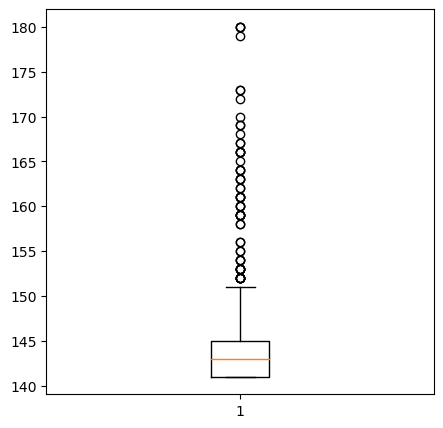

In [20]:
# Plot boxplot

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df_tweet.len_tweet)
plt.show()

In [21]:
# From previous trials tweet 1040331 contains quot and amp
test = df_tweet[df_tweet['ID'] == 1040331]

In [22]:
# After exploring the tweets, 2 specific words were found "quot" and "amp" (i.e. tweet 1040331), remove this words
#and update clean function

def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'[^\w\s]', '', tweet)                 # Remove special characters
    tweet = re.sub(r'\d+', '', tweet)                     # Remove numbers
    tweet = re.sub(r'\bwww\.\S+', '', tweet)              # Remove websites
    tweet = re.sub(r'quot', '', tweet)                    # Remove "quot" anywhere in the word
    tweet = re.sub(r'amp', '', tweet)                 # Remove isolated word "amp"
    # Encode the tweet to UTF-8 to handle special characters
    tweet = tweet.encode('utf-8', errors='ignore').decode('utf-8')
    return tweet

In [23]:
# Apply function and see if it works

df_tweet['TWEET'] = df_tweet['TWEET'].progress_apply(clean_tweet)

  0%|          | 0/716 [00:00<?, ?it/s]

In [24]:
# Re-check lenght

df_tweet['new_len_tweet'] = [len(str(t)) if pd.notna(t) else 0 for t in tqdm(df_tweet.TWEET)]

  0%|          | 0/716 [00:00<?, ?it/s]

In [25]:
df_tweet.head()

,ID,TWEET,len_tweet,new_len_tweet
0,1071,used the term fail whale to a client on a pitch last night from their incomprehension corp twitter is being done much lower in the org,143,135
1,1767,tks pa tapauing croissant tuna knowing dat ive backtoback meetings since morning zuraidah tks buying my fav starbuck mocha frap,142,131
2,6132,long day of moving and painting with the fam they even treated me to a huge mcdonnalds dinner people need to learn about health food,142,134
3,6894,woke up early this morning to not all the way better baby and a i think im sick aaron wife when these powers are combined not good,147,131
4,7017,today is turning into a frustrating exercise of ignore the consultant because we want an easy sale someone else can fix it later on,141,133


In [29]:
# Re-count tweets with lenght>140

counts = 0
for i in tqdm(df_tweet['TWEET'], total=len(df_tweet)):
    if len(i) > 140:
        counts = counts + 1
print('Total of tweets with more than 140 characters: ' + str(counts))

  0%|          | 0/716 [00:00<?, ?it/s]

Total of tweets with more than 140 characters: 87


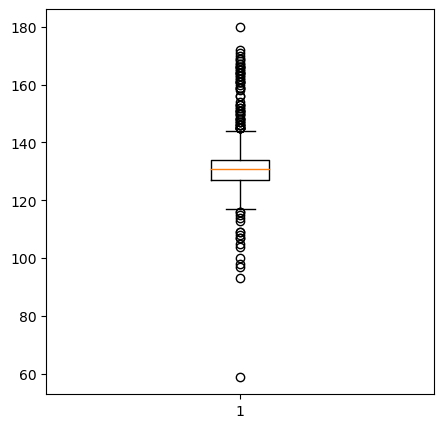

In [26]:
# Plot boxplot

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df_tweet.new_len_tweet)
plt.show()

In [27]:
# Check tweet 1040331

print(df_tweet[df_tweet['ID'] == 1040331])
print(test, '\n')

          ID  \
452  1040331   

                                                                                                                                   TWEET  \
452  it is late  i do have a real job to be at in the am so i should get some sleep  keep on retweeting please thank you for the support   

     len_tweet  new_len_tweet  
452        142            131  
          ID  \
452  1040331   

                                                                                                                                              TWEET  \
452  it is late amp i do have a quotrealquot job to be at in the am so i should get some sleep  keep on retweeting please thank you for the support   

     len_tweet  
452        142   



In [31]:
# now that the number of tweets is reduced to 87, create a new list to check what's in the tweets

len_tweet2 = []

for index, row in tqdm(df_tweet.iterrows(), total=len(df_tweet)):
    if len(row['TWEET']) > 140:
        len_tweet2.append({'ID': row['ID'], 'TWEET': row['TWEET']})
#df_len_tweet2 = pd.DataFrame(len_tweet2)
#print(len_tweet)
df_tweet2 = pd.DataFrame(len_tweet2)

# Re-check lenght

df_tweet2['new_len_tweet'] = [len(str(t)) if pd.notna(t) else 0 for t in tqdm(df_tweet2.TWEET)]

  0%|          | 0/716 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

In [32]:
df_tweet2.head()

,ID,TWEET,new_len_tweet
0,248973,ðññ openoffice ð²ñððµñðð ñð²ð¾ðµð¹ ð½ðµññððððñð½ð¾ññññ ðñð ñððð¾ñðµ ñ ñððððñðð¼ð ð²ñðµð¼ðµð½ð½ð¾ ððµñðµðµðððñ ð¾ðñðñð½ð¾ ð½ð m ðñð²ññð²ññ ñðµðñ ðñðµððñðµððµð¼,159
1,271633,àªààª àªàªààª àªàªàª àªà àªààª àªàª¾àªà àªàªàª¾àªµààªààª àªà it says you have not confirmed earlier registration let me try with my yahoo id,142
2,272536,ððð³ðññððð¾ ððð²ððµð½ððµ ðºð¾ð½ñððºñð¾ð² ñ gmail ñð½ðñððð ðð¾ðºðððð ññð¾ ðð¾ððð²ðð following \tð followers ð½ð¾ ñðµð¹ñðñ ð ñ ñð½ð¾ð²ð ð½ðµñ,141
3,283722,ññðºðð²ð¾ ñð¾ ðñðð²ð¾ð¾ñ ð¾ñð¾ð½ð½ñ ð¾ñð³ðð½ð ð¼ð¾ðñññ ðñð¾ððñð sharenetua ð²ððñð½ððº ð½ñðð ðð ðºð¾ñðð¾ð½ð¾ð¼ ððñð½ ð ñðµñð²ððº ñð¾ ð² ððñð²ñ,142
4,322655,ð¾ðððð½ð¾ ññð¾ ð¼ð½ð¾ð³ððµ ñð²ðñðµññð½ðµ ð½ðµ ððð¼ðµñðññ ðºð¾ð³ðð ðð¼ ð¾ñðñðð²ðñðµññ reply ð direct ð¼ð¾ðð½ð¾ ð¾ñðñðð²ðñññ ñð¾ðñðºð¾ ñðµð¼ ðºñð¾ ñðµðñ ñðñððµñ,159


In [33]:
# Now those tweets have no useful information, now replace tweet for "neutral" so it won't mess with the sentiment analysis

null_tweet = df_tweet2['ID']

for t in tqdm(null_tweet, total=len(null_tweet)):
    if t in df1['ID'].values:
        df1.loc[df1['ID'] == t, 'TWEET'] = "neutral"

# Check for long tweets again

counts = 0
for i in tqdm(df1['TWEET'], total=len(df1)):
    if len(i) > 140:
        counts = counts + 1
print('Total of tweets with more than 140 characters: ' + str(counts))

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/1600000 [00:00<?, ?it/s]

Total of tweets with more than 140 characters: 629


In [34]:
# Apply function to df1

df1['TWEET'] = df1['TWEET'].progress_apply(clean_tweet)

  0%|          | 0/1600000 [00:00<?, ?it/s]

In [35]:
# Final count

counts = 0
for i in tqdm(df1['TWEET'], total=len(df1)):
    if len(i) > 140:
        counts = counts + 1
print('Total of tweets with more than 140 characters: ' + str(counts))

  0%|          | 0/1600000 [00:00<?, ?it/s]

Total of tweets with more than 140 characters: 0


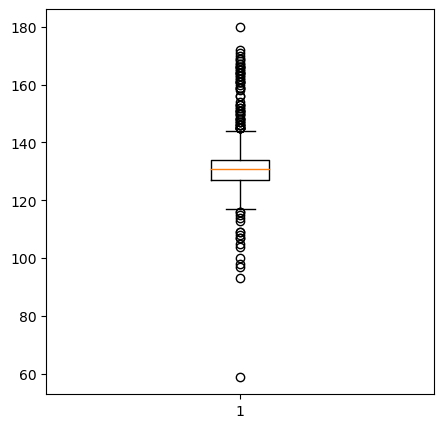

In [36]:
# Plot boxplot

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df_tweet.new_len_tweet)
plt.show()

In [42]:
sia = SentimentIntensityAnalyzer()
print(sia.polarity_scores('NO'))
print(sia.polarity_scores('YES'))
print(sia.polarity_scores('NEU'))

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.296}
{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4019}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
